In [42]:
# imports
import polars as pl
import polars.selectors as cs
import os
from statistics_utils import ne2cc, build_country_code_dicts
import plotly.express as px
import json
import plotly.graph_objects as go
import pandas
import altair as alt
import geopandas as gpd
#import contextily as cx
from shapely.geometry import Point, LineString, Polygon
pl.Config.set_tbl_rows(20)

polars.config.Config

In [43]:
def load_and_concat_parquet_files(path):
    dfs = []
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        if file_path.endswith('.parquet'):
            dfs.append(convert_types(pl.read_parquet(file_path).with_columns([pl.lit(file[0:2]).alias("ReferringCountry")])))
    if not dfs:
        return pl.DataFrame()
    combined_df = dfs[0]
    for df in dfs[1:]:
        combined_df = pl.concat([combined_df,df], how="diagonal")
    return combined_df

def convert_types(df):
    for col in df.columns:
        if df[col].dtype != pl.String:
            df = df.with_columns(df[col].cast(pl.String))
    return df

path = "/home/simon/parliamint/ParlaMint_edgelists"
df = load_and_concat_parquet_files(path)
#df = df.drop("[0.002s][warning][perf,memops] Cannot use file /tmp/hsperfdata_kopp/3612625 because it is locked by another process (errno = 11)")

df = df.with_columns(
    pl.col("Date").str.strptime(pl.Date, "%Y-%m-%d")
)
print(df)

shape: (1_818_766, 25)
┌───────────┬───────────┬───────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ text_id   ┆ name_type ┆ position  ┆ entity   ┆ … ┆ Speaker_b ┆ target_co ┆ source_co ┆ Referring │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆   ┆ irth      ┆ untry     ┆ untry     ┆ Country   │
│ str       ┆ str       ┆ str       ┆ str      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│           ┆           ┆           ┆          ┆   ┆ str       ┆ str       ┆ str       ┆ str       │
╞═══════════╪═══════════╪═══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ ParlaMint ┆ LOC       ┆ ParlaMint ┆ europe   ┆ … ┆ null      ┆ europe    ┆ PT        ┆ PT        │
│ -PT_2015- ┆           ┆ -PT_2015- ┆          ┆   ┆           ┆           ┆           ┆           │
│ 03-20.u83 ┆           ┆ 03-20.seg ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆           ┆ 287…      ┆          ┆   ┆           ┆    

In [44]:
print(df.group_by("entity").len().sort("len", descending=True).filter())

shape: (270, 2)
┌────────────────────┬────────┐
│ entity             ┆ len    │
│ ---                ┆ ---    │
│ str                ┆ u32    │
╞════════════════════╪════════╡
│ europe             ┆ 337559 │
│ germany            ┆ 84267  │
│ russia             ┆ 81258  │
│ united states      ┆ 75534  │
│ ukraine            ┆ 60249  │
│ kosovo             ┆ 48416  │
│ france             ┆ 44566  │
│ spain              ┆ 40984  │
│ syria              ┆ 39111  │
│ china              ┆ 37667  │
│ …                  ┆ …      │
│ brunei darussalam  ┆ 3      │
│ west america       ┆ 2      │
│ east australia     ┆ 2      │
│ south west asia    ┆ 2      │
│ southern asia      ┆ 1      │
│ türkiye            ┆ 1      │
│ south west africa  ┆ 1      │
│ north east africa  ┆ 1      │
│ northern australia ┆ 1      │
│ norfolk island     ┆ 1      │
└────────────────────┴────────┘


In [45]:
dicts = build_country_code_dicts()
def ne2cc_s(x):
    return ne2cc(x, dicts[0], dicts[1])


# Neighbor investigation (Simon)

neighbor json file was created in `border_finder_new.py` using data from the restcountries file

In [ ]:
# creating base dataset (all countries)

with open("/home/simon/parlianets/neighbors_iso2.json", "r") as f:
    neighbors_map = json.load(f)

dfbak = df
# 1) convert to pandas
pdf = df.to_pandas()

# 2) row-wise apply
pdf["is_neighbor"] = pdf.apply(
    lambda r: r.target_country in neighbors_map.get(r.source_country, []),
    axis=1
)

# 3) back to Polars (if you still want Polars for grouping)
df2 = pl.from_pandas(pdf)

result = (
    df2
    .group_by("source_country", maintain_order=True)
    .agg([
      (pl.sum("is_neighbor") / pl.count() * 100).round(2).alias("neighbors_rel"),
      (((pl.count() - pl.sum("is_neighbor")) / pl.count()) * 100)
        .round(2).alias("non_neighbors_rel")
    ])
)

print(result)

shape: (26, 3)
┌────────────────┬───────────────┬───────────────────┐
│ source_country ┆ neighbors_rel ┆ non_neighbors_rel │
│ ---            ┆ ---           ┆ ---               │
│ str            ┆ f64           ┆ f64               │
╞════════════════╪═══════════════╪═══════════════════╡
│ PT             ┆ 6.45          ┆ 93.55             │
│ RS             ┆ 45.32         ┆ 54.68             │
│ CZ             ┆ 19.8          ┆ 80.2              │
│ IS             ┆ 0.0           ┆ 100.0             │
│ GR             ┆ 4.14          ┆ 95.86             │
│ ES             ┆ 8.1           ┆ 91.9              │
│ BE             ┆ 21.1          ┆ 78.9              │
│ LV             ┆ 32.61         ┆ 67.39             │
│ GB             ┆ 0.0           ┆ 100.0             │
│ BG             ┆ 12.83         ┆ 87.17             │
│ …              ┆ …             ┆ …                 │
│ TR             ┆ 28.14         ┆ 71.86             │
│ FI             ┆ 22.18         ┆ 77.82          

/tmp/ipykernel_114858/2846191023.py:21: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum("is_neighbor") / pl.count() * 100).round(2).alias("neighbors_rel"),
/tmp/ipykernel_114858/2846191023.py:22: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (((pl.count() - pl.sum("is_neighbor")) / pl.count()) * 100)


In [58]:
import polars as pl
import matplotlib.pyplot as plt

# assume `df` is your Polars DataFrame

# Extract data as Python lists
def visualize_neighbor_references(df, plot_a_title, plot_b_title):
    countries       = df['source_country'].to_list()
    neighbors       = df['neighbors_rel'].to_list()
    non_neighbors   = df['non_neighbors_rel'].to_list()

    # 1) Stacked bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(countries, neighbors,       label='Neighbors')
    #ax.bar(countries, non_neighbors,   bottom=neighbors, label='Non-Neighbors')

    ax.set_xlabel('Country')
    ax.set_ylabel('Relative Value (%)')
    ax.set_title(plot_a_title)
    #ax.set_title('Neighbors vs. Non-Neighbors by Country')
    ax.legend()
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


    # 2) Mean ± SD across all countries
    # compute via Polars
    stats = df.select([
        pl.col('neighbors_rel').mean().alias('μ_neighbors'),
        pl.col('neighbors_rel').std(ddof=1).alias('σ_neighbors'),
        pl.col('non_neighbors_rel').mean().alias('μ_non_neighbors'),
        pl.col('non_neighbors_rel').std(ddof=1).alias('σ_non_neighbors'),
    ])

    # pull out as floats
    μ_n  = stats['μ_neighbors'][0]
    σ_n  = stats['σ_neighbors'][0]
    μ_nn = stats['μ_non_neighbors'][0]
    σ_nn = stats['σ_non_neighbors'][0]

    fig, ax = plt.subplots(figsize=(6, 5))
    labels = ['Neighbors', 'Non-Neighbors']
    labels = ['Neighbors', 'Non-Neighbors']
    means  = [μ_n, μ_nn]
    stds   = [σ_n, σ_nn]

    #ax.bar(labels, means, yerr=stds, capsize=5, width=0.6)
    # plot means as highlighted points with error bars
    x = range(len(labels))
    ax.errorbar(
        x, means, yerr=stds,
        fmt='o',            # circle marker
        markersize=8,
        markeredgewidth=2,
        capsize=5
    )
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    ax.set_ylabel('Relative Value (%)')
    ax.set_title(plot_b_title)
    #ax.set_title('Mean ± SD of Relative Values Across All Countries')
    plt.tight_layout()
    plt.show()


## base

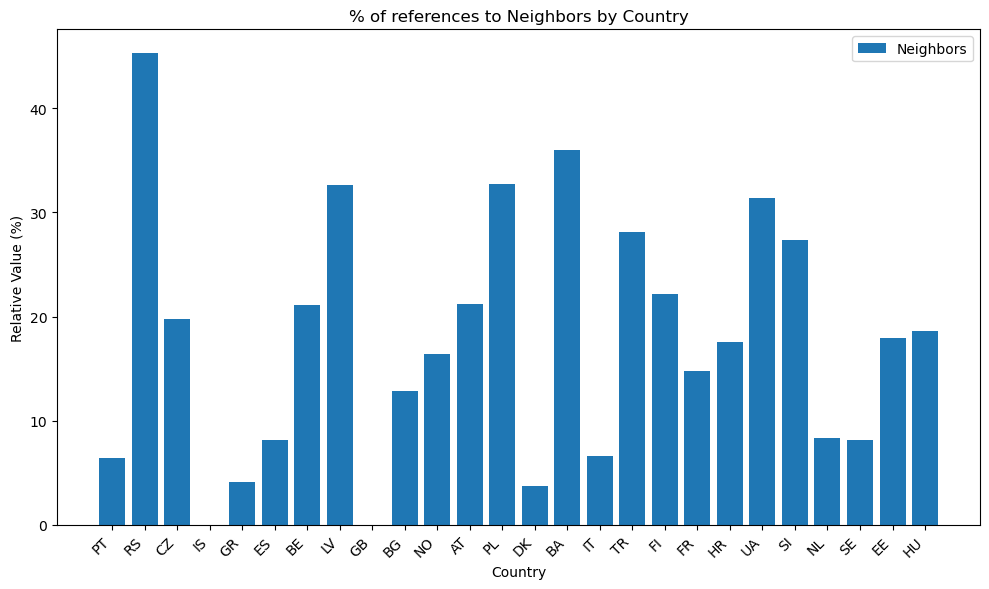

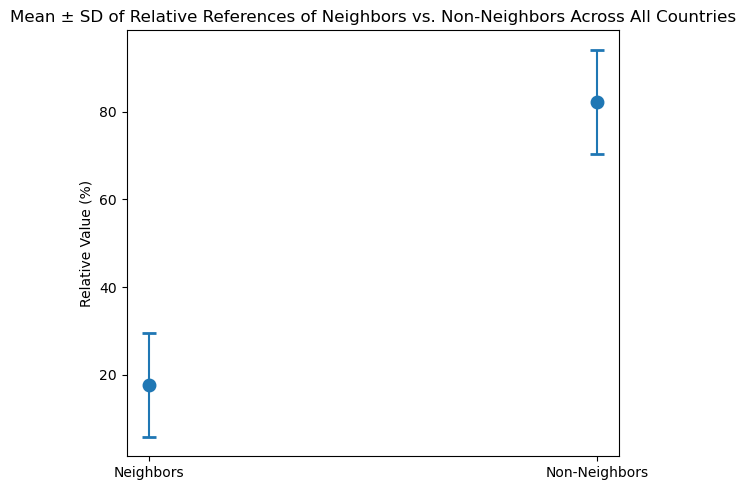

In [59]:
visualize_neighbor_references(result, "% of references to Neighbors by Country", "Mean ± SD of Relative References of Neighbors vs. Non-Neighbors Across All Countries")

## scaling with number of neighbors

In [ ]:
total_counts = df.group_by("ReferringCountry").len().rename({"len": "total"})

# Step 2: Count pairs and compute proportion
result = (
    df.group_by("ReferringCountry", "ReferredCountry")
      .len()
      .join(total_counts, on="ReferringCountry")
      .with_columns(
          (pl.col("len") / pl.col("total")).alias("proportion")
      )
      .sort("proportion", descending=True)
)
result

In [36]:
df.group_by("ReferringCountry", "ReferredCountry", "Party_orientation").len().sort("len", descending=True)


ReferringCountry,ReferredCountry,Party_orientation,len
str,str,str,u32
"""RS""","""XK""","""Far-right""",12603
"""RS""","""XK""","""Centre-left""",8144
"""DK""","""GL""","""Left""",5941
"""RS""","""XK""","""Big tent""",5764
"""RS""","""XK""","""Right""",5209
"""RS""","""XK""","""-""",4069
"""DK""","""GL""","""Centre-right""",3910
"""DK""","""GL""","""Centre-left""",3902
"""TR""","""SY""","""Centre-left""",3781
